# Set up

In [469]:
## prepare packages
#%pip install -U pandas
#%pip install -U matplotlib
#%pip install -U gensim
#%pip install -U scipy
#%pip install -U pyLDAvis
#%pip install -U plotly
#%pip install -U 'nbformat>=4.2.0'
#%pip install -U multiprocess
#!conda update conda -y

In [470]:
## import modules
import os, sys
## maake accessible files on level immediately above 
sys.path.append(os.path.join(os.path.dirname("__file__"), ".."))
## import other modules
import re
import gzip, glob
import unicodedata
## https://stackoverflow.com/questions/41385708/multiprocessing-example-giving-attributeerror
#import multiprocessing as mp # fails on IPython environment
import multiprocess as mp # provides Pool

# Preparation 1

In [471]:
## parameters
verbose              = True
save_results         = False
targets_csv          = True
reload_modules       = True

## source sampling
source_sampling      = True
source_sampling_rate = 0.04 # optimal values depend on kinds of source

## doc settings # The longer sentences become, the less precise pairing becomes
size_measures        = [ 'sp_size', 'sn_size' ]
size_measure         = size_measures[1]
max_doc_size         = 11 # values larger than 10 take considerably longer to complete
min_doc_size         =  5

## preprocessing settings
lower_chars          = True
strip_accents        = False
add_boundaries       = True
boundary_symbol      = '#'  # requires more processing resource
if add_boundaries:
    hash_status = "-hashed"
else:
    hash_status = ""

## term settings
ngram_is_inclusive    = True # takes longer to complete but invites sum error if False with larger n, 
inclusion_degree      = 1    # Valid values are {0, 1, 2, ..., None}. With k, n-grams includes (n-k)-grams
print(f"inclusion_degree: {inclusion_degree}")

max_gap_size_factor   = 0.6 # It takes time at valuers larger than 0.5 with larger n such as n = 5
max_gap_size          = round(max_doc_size * max_gap_size_factor) # This needs to be smaller than other cases.
print(f"max_gap_size: {max_gap_size}")

## Skippy n-gram の隙間を表わす記号
gap_mark            = "…"

## spell term と sound term の連結記号
pair_mark           = " :: "

## set spell term_type
sp_term_types  = [ 'sp_1gram',
                  'sp_2gram', 'sp_3gram', 'sp_4gram', 'sp_5gram',
                 'sp_sk2gram', 'sp_sk3gram', 'sp_sk4gram', 'sp_sk5gram' ]
sp_term_type   = sp_term_types[4]
print(f"sp_term_type: {sp_term_type}")

## set sound term_type
sn_term_types = [ 'sn_1gram',
                 'sn_2gram', 'sn_3gram', 'sn_4gram', 'sn_5gram',
                 'sn_sk2gram', 'sn_sk3gram', 'sn_sk4gram', 'sn_sk5gram' ]
sn_term_type = sn_term_types[4]
print(f"sn_term_type: {sn_term_type}")

## n_for_ngram
n_sp = sp_term_type.split("gram")[0][-1]
n_sn = sn_term_type.split("gram")[0][-1]
n_for_ngram = max(int(n_sp), int(n_sn))
print(f"n_for_ngram: {n_for_ngram}")

inclusion_degree: 1
max_gap_size: 7
sp_term_type: sp_5gram
sn_term_type: sn_5gram
n_for_ngram: 5


In [472]:
## term filtering: some combinations cause "Not all rows sum to 1" error with HDP, but no with LDA
apply_term_freq_filtering  = True
term_minfreq               = 2 # Effective for speeding up
apply_term_abuse_filtering = True
term_abuse_threshold       = 0.1 # Larger values reveal deeper; 0.006 seems to be the smallest

In [609]:
## select HDP or LDA: HDP takes considerably longer to complete than LDA with large n_topics,
## HDP
use_HDP         = True
if use_HDP:
    method_name  = "HDP" # non-executive variable to be used in file names
else:
    method_name  = "LDA"
print(f"method_name: {method_name}")

max_n_topics    = 70
print(f"max_n_topics for HDP: {max_n_topics}")

## LDA
n_topics  = max_n_topics # 精度にはあまり影響しない？
print(f"n_topics for LDA: {n_topics}")

##
n_docs_to_show  = 30
n_terms_to_show = 100
print(f"n_docs_to_show: {n_docs_to_show}")
print(f"n_terms_to_show: {n_terms_to_show}")

## tSNE
top_perplexity_reduct_rate = 0.33
print(f"top_perplexity_reduct_rate: {top_perplexity_reduct_rate}")

# saving output
save_LDAvis          = False
save_topic_structure = False
print(f"save_LDAvis: {save_LDAvis}")
print(f"save_topic_structure: {save_topic_structure}")

# hierarchical clustering
hc_sampling_rate = 0.01
print(f"hc_sampling_rate: {hc_sampling_rate}")

method_name: HDP
max_n_topics for HDP: 70
n_topics for LDA: 70
n_docs_to_show: 30
n_terms_to_show: 100
top_perplexity_reduct_rate: 0.33
save_LDAvis: False
save_topic_structure: False
hc_sampling_rate: 0.01


In [539]:
## get data
import glob
data_dir1 = "data/open-dict-ipa/data1"
data_dir2 = "data/open-dict-ipa/data1a"
files = [ ]
for dir in [ data_dir1, data_dir2 ]:
    gz_files = glob.glob(f"{dir}/*.gz")
    files.extend(gz_files)
    csv_files = glob.glob(f"{dir}/*.csv")
    files.extend(csv_files)
    txt_files = glob.glob(f"{data_dir2}/*.txt")
    files.extend(txt_files)
#
files

['data/open-dict-ipa/data1/yue.csv.gz',
 'data/open-dict-ipa/data1/vi_S.csv.gz',
 'data/open-dict-ipa/data1/de.csv.gz',
 'data/open-dict-ipa/data1/jam.csv.gz',
 'data/open-dict-ipa/data1/fa.csv.gz',
 'data/open-dict-ipa/data1/zh_hant.csv.gz',
 'data/open-dict-ipa/data1/sw.csv.gz',
 'data/open-dict-ipa/data1/ar.csv.gz',
 'data/open-dict-ipa/data1/es_MX.csv.gz',
 'data/open-dict-ipa/data1/vi_C.csv.gz',
 'data/open-dict-ipa/data1/ma.csv.gz',
 'data/open-dict-ipa/data1/fi.csv.gz',
 'data/open-dict-ipa/data1/eo.csv.gz',
 'data/open-dict-ipa/data1/fr_QC.csv.gz',
 'data/open-dict-ipa/data1/es_ES.csv.gz',
 'data/open-dict-ipa/data1/en_US.csv.gz',
 'data/open-dict-ipa/data1/en_UK.csv.gz',
 'data/open-dict-ipa/data1/nb.csv.gz',
 'data/open-dict-ipa/data1/nl.csv.gz',
 'data/open-dict-ipa/data1/sv.csv.gz',
 'data/open-dict-ipa/data1/or.csv.gz',
 'data/open-dict-ipa/data1/zh_hans.csv.gz',
 'data/open-dict-ipa/data1/fr_FR.csv.gz',
 'data/open-dict-ipa/data1/vi_N.csv.gz',
 'data/open-dict-ipa/data1/j

In [540]:
## select language and file
lang_names = {  'ar' : 'Arabic',  # 0
                'de' : 'German',  # 1
                'en' : 'English', # 2
                'es' : 'Spanish', # 3
                'fr' : 'French',  # 4
                'sw' : 'Swahili'  # 5
            }
#
lang_keys = [ 'ar', 'de', 'en', 'es', 'fr', 'sw' ]
#
lang_key  = lang_keys[2]
lang_name = lang_names[lang_key]
lang_attr = ""
print(f"lang_name: {lang_name} ({lang_attr}) [lang_key: {lang_key}]")
# aliases
target_lang_dict = lang_names
target_lang_keys = lang_keys
target_lang_key  = lang_key
target_lang_attr = lang_attr
#
files = [ file for file in files if f"/{lang_key}" in file ]
print(files)
if len(lang_attr) > 0:
    print(f"lang_attr: {lang_attr}")
    selected_files = [ file for file in files if lang_attr in file ]
else:
    selected_files = files
selected_files
if len(selected_files) == 0:
    exit()

lang_name: English () [lang_key: en]
['data/open-dict-ipa/data1/en_US.csv.gz', 'data/open-dict-ipa/data1/en_UK.csv.gz', 'data/open-dict-ipa/data1/en_US.csv']


In [541]:
## build data from files
import re, unicodedata
import pandas as pd

check = False
target_file = selected_files[0]
col_names = [ 'sp_word', 'sn_word' ]
if target_file.endswith(".gz"):
    with gzip.open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
else:
    with open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
#
raw_df

,sp_word,sn_word
0,'bout,/ˈbaʊt/
1,'cause,/kəz/
2,'course,/ˈkɔɹs/
3,'cuse,/ˈkjuz/
4,'em,/əm/
...,...,...
125922,zysk,/ˈzaɪsk/
125923,zyskowski,/zɪˈskɔfski/
125924,zyuganov,"/ˈzjuɡɑnɑv/, /ˈzuɡɑnɑv/"
125925,zyuganov's,"/ˈzjuɡɑnɑvz/, /ˈzuɡɑnɑvz/"


In [542]:
## modify spell
raw_df['sp_word'] = raw_df['sp_word'].apply(lambda x: unicodedata.normalize('NFC', str(x)))
if lower_chars:
    raw_df['sp_word'] = raw_df['sp_word'].apply(lambda x: x.lower())

## modify sound symbols
raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: unicodedata.normalize('NFC', str(x)))
raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: re.sub(r"/", "", x))
raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: x.split(",")[0]) # pick up only the first
if strip_accents:
    raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: re.sub(r'"', "", x))
    raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: re.sub(r"[ˈˌ]", "", x))
#
raw_df

,sp_word,sn_word
0,'bout,ˈbaʊt
1,'cause,kəz
2,'course,ˈkɔɹs
3,'cuse,ˈkjuz
4,'em,əm
...,...,...
125922,zysk,ˈzaɪsk
125923,zyskowski,zɪˈskɔfski
125924,zyuganov,ˈzjuɡɑnɑv
125925,zyuganov's,ˈzjuɡɑnɑvz


In [543]:
## build df
dids = [ ]
sids = [ ]
Spells = [ ]
Sounds = [ ]
for i, row in raw_df.iterrows():
    spell = row['sp_word']
    sound = row['sn_word']
    if len(spell) > 0 and len(sound) > 0:
        dids.append(i + 1)
        sids.append(i + 1)
        Spells.append(spell)
        Sounds.append(sound)
#
var_names = [ 'did', 'sid', 'sp_word', 'sn_word',
            'sp_size', 'sn_size', 'paired_terms', 
            'sp_1gram', 'sp_2gram', 'sp_3gram',
            'sp_sk2gram', 'sp_sk3gram',
            'sn_1gram', 'sn_2gram', 'sn_3gram', 
            'sn_sk2gram', 'sn_sk3gram' ]
df = pd.DataFrame()
df['did'] = dids
df['sid'] = sids
df['sp_word'] = Spells
df['sn_word'] = Sounds
#
df[var_names[:4]]

,did,sid,sp_word,sn_word
0,1,1,'bout,ˈbaʊt
1,2,2,'cause,kəz
2,3,3,'course,ˈkɔɹs
3,4,4,'cuse,ˈkjuz
4,5,5,'em,əm
...,...,...,...,...
125922,125923,125923,zysk,ˈzaɪsk
125923,125924,125924,zyskowski,zɪˈskɔfski
125924,125925,125925,zyuganov,ˈzjuɡɑnɑv
125925,125926,125926,zyuganov's,ˈzjuɡɑnɑvz


In [544]:
# filter hyphenated words
len1 = len(df)
df = df[ df['sp_word'].apply(lambda x: x.find("-")) < 0 ]
print(f"discarded {len1- len(df)} rows")

discarded 1011 rows


In [545]:
## tokenization
import gzip, re
import pandas as pd
check = False
Snx = [ ]
Spx = [ ]
for i, row in df.iterrows():
    Spt = row['sp_word']
    Snt = row['sn_word']
    split_pattern = r""
    ## Spell
    sp_seg = [ x for x in re.split(split_pattern, Spt) if len(x) > 0 ]
    if check:
        print(sp_seg)
    Spx.append(sp_seg)
    ## Sound
    sn_seg = [ x for x in re.split(split_pattern, Snt) if len(x) > 0 ]
    if check:
        print(sn_seg)
    Snx.append(sn_seg)
## Spell
try:
    df['sp_1gram'] = Spx
except ValueError:
    pass
## Sound
try:
    df['sn_1gram'] = Snx
except ValueError:
    pass
## check result
if verbose:
    df

In [546]:
## add size columns
df['sp_size'] = df['sp_1gram'].apply(lambda x: len(x))
df['sn_size'] = df['sn_1gram'].apply(lambda x: len(x))
if verbose:
    df

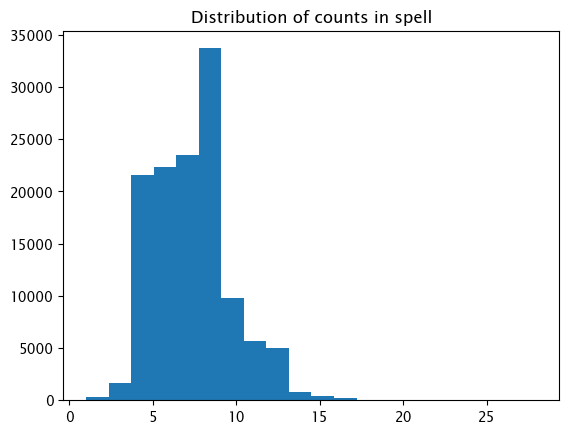

In [547]:
## 語の綴り文字数の分布
import matplotlib.pyplot as plt
plt.hist(df['sp_size'], bins = 20)
plt.title(f"Distribution of counts in spell")
plt.show()

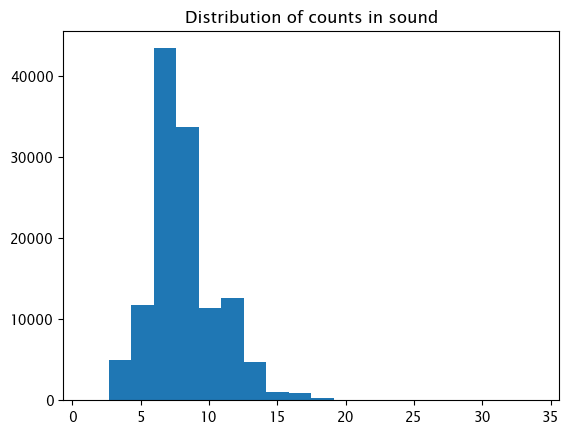

In [548]:
## 語の発音記号数の分布
import matplotlib.pyplot as plt
plt.hist(df['sn_size'], bins = 20)
plt.title(f"Distribution of counts in sound")
plt.show()

In [549]:
## sampling
if source_sampling:
    original_size = len(df)
    sample_size   = round(len(df) * source_sampling_rate)
    df = df.sample(sample_size)
    print(f"sampled {len(df)} ({source_sampling_rate:0.3f}) rows by discarding {original_size - len(df)} rows")

sampled 4997 (0.040) rows by discarding 119919 rows


# build terms, part 1

In [550]:
## 長さで濾過
original_size = len(df)
print(f"discarding pairs whose {size_measure} part has less than {min_doc_size} chars")
df = df[df[size_measure] >= min_doc_size]

print(f"discarding pairs whose {size_measure} part has more than {max_doc_size} chars")
df = df[df[size_measure] < max_doc_size]

current_size = len(df)
size_diff = original_size - current_size
print(f"{size_diff} ({size_diff/original_size:.3f}) pairs were removed")
print(f"{current_size} pairs remain")

discarding pairs whose sn_size part has less than 5 chars
discarding pairs whose sn_size part has more than 11 chars
953 (0.191) pairs were removed
4044 pairs remain


In [551]:
## add boundaries
if add_boundaries:
    df['sp_word'] = df['sp_word'].apply(lambda x: f"{boundary_symbol}{x}{boundary_symbol}")
    df['sn_word'] = df['sn_word'].apply(lambda x: f"{boundary_symbol}{x}{boundary_symbol}")
    df[['sp_word', 'sn_word']]

In [552]:
## add 1gram
import re
w_splitter = r""
df['sp_1gram'] = [ [ x for x in re.split(w_splitter, w) if len(x) > 0 ] for w in df['sp_word'] ]
df['sn_1gram'] = [ [ x for x in re.split(w_splitter, w) if len(x) > 0 ] for w in df['sn_word'] ]
df[['sp_1gram', 'sn_1gram']]

,sp_1gram,sn_1gram
51804,"[#, h, o, c, h, s, t, e, t, l, e, r, #]","[#, ˈ, h, ɑ, k, s, t, ɛ, t, ɫ, ɝ, #]"
46687,"[#, g, r, e, t, z, i, n, g, e, r, #]","[#, ˈ, ɡ, ɹ, ɛ, t, z, ɪ, ŋ, ɝ, #]"
47079,"[#, g, r, o, u, t, i, n, g, #]","[#, ˈ, ɡ, ɹ, a, ʊ, t, ɪ, ŋ, #]"
125290,"[#, z, a, v, a, d, i, l, #]","[#, z, ɑ, v, ɑ, ˈ, d, i, ɫ, #]"
98569,"[#, s, a, n, t, i, n, #]","[#, ˈ, s, æ, n, t, ɪ, n, #]"
...,...,...
95348,"[#, r, i, e, s, l, i, n, g, #]","[#, ˈ, ɹ, i, z, ɫ, ɪ, ŋ, #]"
25429,"[#, c, r, o, u, t, h, a, m, e, l, #]","[#, ˈ, k, ɹ, a, ʊ, θ, ə, m, ɛ, ɫ, #]"
108843,"[#, s, t, r, a, u, s, s, #]","[#, ˈ, s, t, ɹ, a, ʊ, s, #]"
115784,"[#, t, r, u, s, s, #]","[#, ˈ, t, ɹ, ə, s, #]"


In [553]:
## inspect frequent tokens in sp_1gram
from collections import Counter
sp_chars_all = [ ] 
[ sp_chars_all.extend(list(x)) for x in df['sp_1gram'] ]
sp_char_freqs = Counter(sp_chars_all)
## Show most frequent 10 segments
sｐ_char_freqs.most_common(10)

[('#', 8088),
 ('e', 3246),
 ('a', 2414),
 ('r', 2271),
 ('s', 2155),
 ('n', 1999),
 ('i', 1935),
 ('o', 1721),
 ('l', 1667),
 ('t', 1525)]

In [554]:
## inspect frequent tokens in sn_1gram
from collections import Counter
sn_chars_all = [ ] 
[ sn_chars_all.extend(list(x)) for x in df['sn_1gram'] ]
sn_char_freqs = Counter(sn_chars_all)
## Show most frequent 10 segments
sn_char_freqs.most_common(10)

[('#', 8088),
 ('ˈ', 4085),
 ('ə', 1888),
 ('ɪ', 1877),
 ('n', 1651),
 ('ɫ', 1430),
 ('t', 1426),
 ('s', 1404),
 ('ɹ', 1305),
 ('k', 1196)]

In [555]:
## Install nltk if necessary
#!pip install -U nltk

n-grams の構築

In [556]:
def gen_ngrams_from_str(t: str, n: int, sep: str = r"", joint: str = "", check = False):
    'returns the list of character n-grams from a given string'
    import re
    segs = [ x for x in re.split(sep, t) if len(x) > 0 ]
    if check:
        print(segs)
    ## short input
    if len(segs) <= n:
        return segs
    ## long enough input
    G = [ ]
    for i in range(len(segs)):
        try:
            b = segs[ i : i + n ]
            if check:
                print(b)
            c = joint.join(b)
            if check:
                print(c)
            if len(c) == n:
                G.append(c)
        except IndexError:
            pass
    return G

In [557]:
## generic n-gram generation function
def add_ngrams(dfx, n_for_ngram: int, prefix: str = "", skippy: bool = False, skippiness_symbol: str = "sk", max_distance = None, seg_joint: str = "", gap_mark: str = "…", inclusive: bool = True, inclusion_degree = None, check: bool = False):
    "add ngram col to the dfx given"
    import gen_ngrams
    ## set variable names
    source_var_name = f"{prefix}1gram"
    if skippy:
        target_var_name  = f"{prefix}{skippiness_symbol}{n_for_ngram}gram"
        if n_for_ngram == 2:
            sub_var_name = f"{prefix}{n_for_ngram - 1}gram"
        else:
            sub_var_name = f"{prefix}{skippiness_symbol}{n_for_ngram - 1}gram"
            
    else:
        target_var_name  = f"{prefix}{n_for_ngram}gram"
        sub_var_name     = f"{prefix}{n_for_ngram - 1}gram"
    if check:
        print(f"source_var_name: {source_var_name}")
        print(f"target_var_name: {target_var_name}")
        print(f"sub_var_name: {sub_var_name}")
        
    ## 1gram
    unigrams = dfx[source_var_name]
    
    ## ngram
    pool = mp.Pool (processes = max(os.cpu_count() - 1, 1))
    if skippy:
        ngrams = [ gen_ngrams.gen_skippy_ngrams(g, n = n_for_ngram, sep = seg_joint, missing_mark = gap_mark, max_distance = max_distance, check = check) for g in unigrams ]
    else:
        ngrams = [ gen_ngrams.gen_ngrams(g, n = n_for_ngram, sep = seg_joint, check = check) for g in unigrams ]
    
    ## make ngrams inclusive
    if inclusive:
        sub_ngrams = list(dfx[sub_var_name])
        if inclusion_degree is None:
            for i, gram in enumerate(ngrams):
                assert len(ngrams) == len(sub_ngrams)
                supplement = sub_ngrams[i]
                supplement = [ g for g in supplement if len(g) > 0 ]
                if len(supplement) > 0:
                    gram.extend(supplement)
        else:
            min_size = (n_for_ngram - inclusion_degree)
            assert min_size >= 0
            for i, gram in enumerate(ngrams):
                assert len(ngrams) == len(sub_ngrams)
                supplement = sub_ngrams[i]
                supplement = [ g for g in supplement if len(g) >= min_size ]
                if len(supplement) > 0:
                    gram.extend(supplement)
    ## update df
    dfx[target_var_name] = ngrams
    print(dfx[target_var_name])

# Spell n-grams 生成

In [558]:
df.columns
#iter(df['sp_1gram'])

Index(['did', 'sid', 'sp_word', 'sn_word', 'sp_1gram', 'sn_1gram', 'sp_size',
       'sn_size'],
      dtype='object')

In [559]:
## sp_2gram の追加
add_ngrams(df, n_for_ngram = 2, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

51804     [#h, ho, oc, ch, hs, st, te, et, tl, le, er, r...
46687     [#g, gr, re, et, tz, zi, in, ng, ge, er, r#, #...
47079     [#g, gr, ro, ou, ut, ti, in, ng, g#, #, g, r, ...
125290    [#z, za, av, va, ad, di, il, l#, #, z, a, v, a...
98569     [#s, sa, an, nt, ti, in, n#, #, s, a, n, t, i,...
                                ...                        
95348     [#r, ri, ie, es, sl, li, in, ng, g#, #, r, i, ...
25429     [#c, cr, ro, ou, ut, th, ha, am, me, el, l#, #...
108843    [#s, st, tr, ra, au, us, ss, s#, #, s, t, r, a...
115784        [#t, tr, ru, us, ss, s#, #, t, r, u, s, s, #]
79925                [#n, nu, ut, ts, s#, #, n, u, t, s, #]
Name: sp_2gram, Length: 4044, dtype: object


In [560]:
## sp_3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

51804     [#ho, hoc, och, chs, hst, ste, tet, etl, tle, ...
46687     [#gr, gre, ret, etz, tzi, zin, ing, nge, ger, ...
47079     [#gr, gro, rou, out, uti, tin, ing, ng#, #g, g...
125290    [#za, zav, ava, vad, adi, dil, il#, #z, za, av...
98569     [#sa, san, ant, nti, tin, in#, #s, sa, an, nt,...
                                ...                        
95348     [#ri, rie, ies, esl, sli, lin, ing, ng#, #r, r...
25429     [#cr, cro, rou, out, uth, tha, ham, ame, mel, ...
108843    [#st, str, tra, rau, aus, uss, ss#, #s, st, tr...
115784    [#tr, tru, rus, uss, ss#, #t, tr, ru, us, ss, s#]
79925              [#nu, nut, uts, ts#, #n, nu, ut, ts, s#]
Name: sp_3gram, Length: 4044, dtype: object


In [561]:
## sp_4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

51804     [#hoc, hoch, ochs, chst, hste, stet, tetl, etl...
46687     [#gre, gret, retz, etzi, tzin, zing, inge, nge...
47079     [#gro, grou, rout, outi, utin, ting, ing#, #gr...
125290    [#zav, zava, avad, vadi, adil, dil#, #za, zav,...
98569     [#san, sant, anti, ntin, tin#, #sa, san, ant, ...
                                ...                        
95348     [#rie, ries, iesl, esli, slin, ling, ing#, #ri...
25429     [#cro, crou, rout, outh, utha, tham, hame, ame...
108843    [#str, stra, trau, raus, auss, uss#, #st, str,...
115784    [#tru, trus, russ, uss#, #tr, tru, rus, uss, ss#]
79925                [#nut, nuts, uts#, #nu, nut, uts, ts#]
Name: sp_4gram, Length: 4044, dtype: object


In [562]:
## sp_5gram の追加
if "5gram" in sp_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

51804     [#hoch, hochs, ochst, chste, hstet, stetl, tet...
46687     [#gret, gretz, retzi, etzin, tzing, zinge, ing...
47079     [#grou, grout, routi, outin, uting, ting#, #gr...
125290    [#zava, zavad, avadi, vadil, adil#, #zav, zava...
98569     [#sant, santi, antin, ntin#, #san, sant, anti,...
                                ...                        
95348     [#ries, riesl, iesli, eslin, sling, ling#, #ri...
25429     [#crou, crout, routh, outha, utham, thame, ham...
108843    [#stra, strau, traus, rauss, auss#, #str, stra...
115784        [#trus, truss, russ#, #tru, trus, russ, uss#]
79925                      [#nuts, nuts#, #nut, nuts, uts#]
Name: sp_5gram, Length: 4044, dtype: object


In [563]:
## sp_sk2gram の追加
add_ngrams(df, n_for_ngram = 2, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

51804     [#h, #…o, #…c, #…h, #…s, #…t, ho, h…c, h…h, h…...
46687     [#g, #…r, #…e, #…t, #…z, #…i, gr, g…e, g…t, g…...
47079     [#g, #…r, #…o, #…u, #…t, #…i, gr, g…o, g…u, g…...
125290    [#z, #…a, #…v, #…a, #…d, #…i, za, z…v, z…a, z…...
98569     [#s, #…a, #…n, #…t, #…i, #…n, sa, s…n, s…t, s…...
                                ...                        
95348     [#r, #…i, #…e, #…s, #…l, #…i, ri, r…e, r…s, r…...
25429     [#c, #…r, #…o, #…u, #…t, #…h, cr, c…o, c…u, c…...
108843    [#s, #…t, #…r, #…a, #…u, #…s, st, s…r, s…a, s…...
115784    [#t, #…r, #…u, #…s, #…s, #…#, tr, t…u, t…s, t…...
79925     [#n, #…u, #…t, #…s, #…#, nu, n…t, n…s, n…#, ut...
Name: sp_sk2gram, Length: 4044, dtype: object


In [564]:
## sp_sk3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

51804     [#ho, #h…c, #h…h, #h…s, #h…t, #…oc, #…o…h, #…o...
46687     [#gr, #g…e, #g…t, #g…z, #g…i, #…re, #…r…t, #…r...
47079     [#gr, #g…o, #g…u, #g…t, #g…i, #…ro, #…r…u, #…r...
125290    [#za, #z…v, #z…a, #z…d, #z…i, #…av, #…a…a, #…a...
98569     [#sa, #s…n, #s…t, #s…i, #s…n, #…an, #…a…t, #…a...
                                ...                        
95348     [#ri, #r…e, #r…s, #r…l, #r…i, #…ie, #…i…s, #…i...
25429     [#cr, #c…o, #c…u, #c…t, #c…h, #…ro, #…r…u, #…r...
108843    [#st, #s…r, #s…a, #s…u, #s…s, #…tr, #…t…a, #…t...
115784    [#tr, #t…u, #t…s, #t…s, #t…#, #…ru, #…r…s, #…r...
79925     [#nu, #n…t, #n…s, #n…#, #…ut, #…u…s, #…u…#, #…...
Name: sp_sk3gram, Length: 4044, dtype: object


In [565]:
## sp_sk4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

51804     [#hoc, #ho…h, #ho…s, #ho…t, #h…ch, #h…c…s, #h…...
46687     [#gre, #gr…t, #gr…z, #gr…i, #g…et, #g…e…z, #g…...
47079     [#gro, #gr…u, #gr…t, #gr…i, #g…ou, #g…o…t, #g…...
125290    [#zav, #za…a, #za…d, #za…i, #z…va, #z…v…d, #z…...
98569     [#san, #sa…t, #sa…i, #sa…n, #s…nt, #s…n…i, #s…...
                                ...                        
95348     [#rie, #ri…s, #ri…l, #ri…i, #r…es, #r…e…l, #r…...
25429     [#cro, #cr…u, #cr…t, #cr…h, #c…ou, #c…o…t, #c…...
108843    [#str, #st…a, #st…u, #st…s, #s…ra, #s…r…u, #s…...
115784    [#tru, #tr…s, #tr…s, #tr…#, #t…us, #t…u…s, #t…...
79925     [#nut, #nu…s, #nu…#, #n…ts, #n…t…#, #n…s#, #…u...
Name: sp_sk4gram, Length: 4044, dtype: object


In [566]:
## sp_sk5gram の追加
if "5gram" in sp_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

51804     [#hoch, #hoc…s, #hoc…t, #ho…hs, #ho…h…t, #ho…s...
46687     [#gret, #gre…z, #gre…i, #gr…tz, #gr…t…i, #gr…z...
47079     [#grou, #gro…t, #gro…i, #gr…ut, #gr…u…i, #gr…t...
125290    [#zava, #zav…d, #zav…i, #za…ad, #za…a…i, #za…d...
98569     [#sant, #san…i, #san…n, #sa…ti, #sa…t…n, #sa…i...
                                ...                        
95348     [#ries, #rie…l, #rie…i, #ri…sl, #ri…s…i, #ri…l...
25429     [#crou, #cro…t, #cro…h, #cr…ut, #cr…u…h, #cr…t...
108843    [#stra, #str…u, #str…s, #st…au, #st…a…s, #st…u...
115784    [#trus, #tru…s, #tru…#, #tr…ss, #tr…s…#, #tr…s...
79925     [#nuts, #nut…#, #nu…s#, #n…ts#, #…uts#, nuts#,...
Name: sp_sk5gram, Length: 4044, dtype: object


In [567]:
## check result
if "5gram" in sp_term_type:
    var_names = [ 'sp_word', 'sp_sk2gram', 'sp_sk3gram', 'sp_sk4gram', 'sp_sk5gram' ]
else:
    var_names = [ 'sp_word', 'sp_sk2gram', 'sp_sk3gram', 'sp_sk4gram' ]
df[var_names]

,sp_word,sp_sk2gram,sp_sk3gram,sp_sk4gram,sp_sk5gram
51804,#hochstetler#,"[#h, #…o, #…c, #…h, #…s, #…t, ho, h…c, h…h, h…...","[#ho, #h…c, #h…h, #h…s, #h…t, #…oc, #…o…h, #…o...","[#hoc, #ho…h, #ho…s, #ho…t, #h…ch, #h…c…s, #h…...","[#hoch, #hoc…s, #hoc…t, #ho…hs, #ho…h…t, #ho…s..."
46687,#gretzinger#,"[#g, #…r, #…e, #…t, #…z, #…i, gr, g…e, g…t, g…...","[#gr, #g…e, #g…t, #g…z, #g…i, #…re, #…r…t, #…r...","[#gre, #gr…t, #gr…z, #gr…i, #g…et, #g…e…z, #g…...","[#gret, #gre…z, #gre…i, #gr…tz, #gr…t…i, #gr…z..."
47079,#grouting#,"[#g, #…r, #…o, #…u, #…t, #…i, gr, g…o, g…u, g…...","[#gr, #g…o, #g…u, #g…t, #g…i, #…ro, #…r…u, #…r...","[#gro, #gr…u, #gr…t, #gr…i, #g…ou, #g…o…t, #g…...","[#grou, #gro…t, #gro…i, #gr…ut, #gr…u…i, #gr…t..."
125290,#zavadil#,"[#z, #…a, #…v, #…a, #…d, #…i, za, z…v, z…a, z…...","[#za, #z…v, #z…a, #z…d, #z…i, #…av, #…a…a, #…a...","[#zav, #za…a, #za…d, #za…i, #z…va, #z…v…d, #z…...","[#zava, #zav…d, #zav…i, #za…ad, #za…a…i, #za…d..."
98569,#santin#,"[#s, #…a, #…n, #…t, #…i, #…n, sa, s…n, s…t, s…...","[#sa, #s…n, #s…t, #s…i, #s…n, #…an, #…a…t, #…a...","[#san, #sa…t, #sa…i, #sa…n, #s…nt, #s…n…i, #s…...","[#sant, #san…i, #san…n, #sa…ti, #sa…t…n, #sa…i..."
...,...,...,...,...,...
95348,#riesling#,"[#r, #…i, #…e, #…s, #…l, #…i, ri, r…e, r…s, r…...","[#ri, #r…e, #r…s, #r…l, #r…i, #…ie, #…i…s, #…i...","[#rie, #ri…s, #ri…l, #ri…i, #r…es, #r…e…l, #r…...","[#ries, #rie…l, #rie…i, #ri…sl, #ri…s…i, #ri…l..."
25429,#crouthamel#,"[#c, #…r, #…o, #…u, #…t, #…h, cr, c…o, c…u, c…...","[#cr, #c…o, #c…u, #c…t, #c…h, #…ro, #…r…u, #…r...","[#cro, #cr…u, #cr…t, #cr…h, #c…ou, #c…o…t, #c…...","[#crou, #cro…t, #cro…h, #cr…ut, #cr…u…h, #cr…t..."
108843,#strauss#,"[#s, #…t, #…r, #…a, #…u, #…s, st, s…r, s…a, s…...","[#st, #s…r, #s…a, #s…u, #s…s, #…tr, #…t…a, #…t...","[#str, #st…a, #st…u, #st…s, #s…ra, #s…r…u, #s…...","[#stra, #str…u, #str…s, #st…au, #st…a…s, #st…u..."
115784,#truss#,"[#t, #…r, #…u, #…s, #…s, #…#, tr, t…u, t…s, t…...","[#tr, #t…u, #t…s, #t…s, #t…#, #…ru, #…r…s, #…r...","[#tru, #tr…s, #tr…s, #tr…#, #t…us, #t…u…s, #t…...","[#trus, #tru…s, #tru…#, #tr…ss, #tr…s…#, #tr…s..."


# Sound n-grams 生成

In [568]:
## sn_2gram の追加
add_ngrams(df, n_for_ngram = 2, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

51804     [#ˈ, ˈh, hɑ, ɑk, ks, st, tɛ, ɛt, tɫ, ɫɝ, ɝ#, #...
46687     [#ˈ, ˈɡ, ɡɹ, ɹɛ, ɛt, tz, zɪ, ɪŋ, ŋɝ, ɝ#, #, ˈ,...
47079     [#ˈ, ˈɡ, ɡɹ, ɹa, aʊ, ʊt, tɪ, ɪŋ, ŋ#, #, ˈ, ɡ, ...
125290    [#z, zɑ, ɑv, vɑ, ɑˈ, ˈd, di, iɫ, ɫ#, #, z, ɑ, ...
98569     [#ˈ, ˈs, sæ, æn, nt, tɪ, ɪn, n#, #, ˈ, s, æ, n...
                                ...                        
95348     [#ˈ, ˈɹ, ɹi, iz, zɫ, ɫɪ, ɪŋ, ŋ#, #, ˈ, ɹ, i, z...
25429     [#ˈ, ˈk, kɹ, ɹa, aʊ, ʊθ, θə, əm, mɛ, ɛɫ, ɫ#, #...
108843    [#ˈ, ˈs, st, tɹ, ɹa, aʊ, ʊs, s#, #, ˈ, s, t, ɹ...
115784        [#ˈ, ˈt, tɹ, ɹə, əs, s#, #, ˈ, t, ɹ, ə, s, #]
79925         [#ˈ, ˈn, nə, ət, ts, s#, #, ˈ, n, ə, t, s, #]
Name: sn_2gram, Length: 4044, dtype: object


In [569]:
## sn_3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

51804     [#ˈh, ˈhɑ, hɑk, ɑks, kst, stɛ, tɛt, ɛtɫ, tɫɝ, ...
46687     [#ˈɡ, ˈɡɹ, ɡɹɛ, ɹɛt, ɛtz, tzɪ, zɪŋ, ɪŋɝ, ŋɝ#, ...
47079     [#ˈɡ, ˈɡɹ, ɡɹa, ɹaʊ, aʊt, ʊtɪ, tɪŋ, ɪŋ#, #ˈ, ˈ...
125290    [#zɑ, zɑv, ɑvɑ, vɑˈ, ɑˈd, ˈdi, diɫ, iɫ#, #z, z...
98569     [#ˈs, ˈsæ, sæn, ænt, ntɪ, tɪn, ɪn#, #ˈ, ˈs, sæ...
                                ...                        
95348     [#ˈɹ, ˈɹi, ɹiz, izɫ, zɫɪ, ɫɪŋ, ɪŋ#, #ˈ, ˈɹ, ɹi...
25429     [#ˈk, ˈkɹ, kɹa, ɹaʊ, aʊθ, ʊθə, θəm, əmɛ, mɛɫ, ...
108843    [#ˈs, ˈst, stɹ, tɹa, ɹaʊ, aʊs, ʊs#, #ˈ, ˈs, st...
115784    [#ˈt, ˈtɹ, tɹə, ɹəs, əs#, #ˈ, ˈt, tɹ, ɹə, əs, s#]
79925     [#ˈn, ˈnə, nət, əts, ts#, #ˈ, ˈn, nə, ət, ts, s#]
Name: sn_3gram, Length: 4044, dtype: object


In [570]:
## sn_4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

51804     [#ˈhɑ, ˈhɑk, hɑks, ɑkst, kstɛ, stɛt, tɛtɫ, ɛtɫ...
46687     [#ˈɡɹ, ˈɡɹɛ, ɡɹɛt, ɹɛtz, ɛtzɪ, tzɪŋ, zɪŋɝ, ɪŋɝ...
47079     [#ˈɡɹ, ˈɡɹa, ɡɹaʊ, ɹaʊt, aʊtɪ, ʊtɪŋ, tɪŋ#, #ˈɡ...
125290    [#zɑv, zɑvɑ, ɑvɑˈ, vɑˈd, ɑˈdi, ˈdiɫ, diɫ#, #zɑ...
98569     [#ˈsæ, ˈsæn, sænt, æntɪ, ntɪn, tɪn#, #ˈs, ˈsæ,...
                                ...                        
95348     [#ˈɹi, ˈɹiz, ɹizɫ, izɫɪ, zɫɪŋ, ɫɪŋ#, #ˈɹ, ˈɹi,...
25429     [#ˈkɹ, ˈkɹa, kɹaʊ, ɹaʊθ, aʊθə, ʊθəm, θəmɛ, əmɛ...
108843    [#ˈst, ˈstɹ, stɹa, tɹaʊ, ɹaʊs, aʊs#, #ˈs, ˈst,...
115784    [#ˈtɹ, ˈtɹə, tɹəs, ɹəs#, #ˈt, ˈtɹ, tɹə, ɹəs, əs#]
79925     [#ˈnə, ˈnət, nəts, əts#, #ˈn, ˈnə, nət, əts, ts#]
Name: sn_4gram, Length: 4044, dtype: object


In [571]:
## sn_5gram の追加
if "5gram" in sn_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

51804     [#ˈhɑk, ˈhɑks, hɑkst, ɑkstɛ, kstɛt, stɛtɫ, tɛt...
46687     [#ˈɡɹɛ, ˈɡɹɛt, ɡɹɛtz, ɹɛtzɪ, ɛtzɪŋ, tzɪŋɝ, zɪŋ...
47079     [#ˈɡɹa, ˈɡɹaʊ, ɡɹaʊt, ɹaʊtɪ, aʊtɪŋ, ʊtɪŋ#, #ˈɡ...
125290    [#zɑvɑ, zɑvɑˈ, ɑvɑˈd, vɑˈdi, ɑˈdiɫ, ˈdiɫ#, #zɑ...
98569     [#ˈsæn, ˈsænt, sæntɪ, æntɪn, ntɪn#, #ˈsæ, ˈsæn...
                                ...                        
95348     [#ˈɹiz, ˈɹizɫ, ɹizɫɪ, izɫɪŋ, zɫɪŋ#, #ˈɹi, ˈɹiz...
25429     [#ˈkɹa, ˈkɹaʊ, kɹaʊθ, ɹaʊθə, aʊθəm, ʊθəmɛ, θəm...
108843    [#ˈstɹ, ˈstɹa, stɹaʊ, tɹaʊs, ɹaʊs#, #ˈst, ˈstɹ...
115784        [#ˈtɹə, ˈtɹəs, tɹəs#, #ˈtɹ, ˈtɹə, tɹəs, ɹəs#]
79925         [#ˈnət, ˈnəts, nəts#, #ˈnə, ˈnət, nəts, əts#]
Name: sn_5gram, Length: 4044, dtype: object


In [572]:
## sn_sk2gram の追加
add_ngrams(df, n_for_ngram = 2, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

51804     [#ˈ, #…h, #…ɑ, #…k, #…s, #…t, ˈh, ˈ…ɑ, ˈ…k, ˈ…...
46687     [#ˈ, #…ɡ, #…ɹ, #…ɛ, #…t, #…z, ˈɡ, ˈ…ɹ, ˈ…ɛ, ˈ…...
47079     [#ˈ, #…ɡ, #…ɹ, #…a, #…ʊ, #…t, ˈɡ, ˈ…ɹ, ˈ…a, ˈ…...
125290    [#z, #…ɑ, #…v, #…ɑ, #…ˈ, #…d, zɑ, z…v, z…ɑ, z…...
98569     [#ˈ, #…s, #…æ, #…n, #…t, #…ɪ, ˈs, ˈ…æ, ˈ…n, ˈ…...
                                ...                        
95348     [#ˈ, #…ɹ, #…i, #…z, #…ɫ, #…ɪ, ˈɹ, ˈ…i, ˈ…z, ˈ…...
25429     [#ˈ, #…k, #…ɹ, #…a, #…ʊ, #…θ, ˈk, ˈ…ɹ, ˈ…a, ˈ…...
108843    [#ˈ, #…s, #…t, #…ɹ, #…a, #…ʊ, ˈs, ˈ…t, ˈ…ɹ, ˈ…...
115784    [#ˈ, #…t, #…ɹ, #…ə, #…s, #…#, ˈt, ˈ…ɹ, ˈ…ə, ˈ…...
79925     [#ˈ, #…n, #…ə, #…t, #…s, #…#, ˈn, ˈ…ə, ˈ…t, ˈ…...
Name: sn_sk2gram, Length: 4044, dtype: object


In [573]:
## sn_sk3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

51804     [#ˈh, #ˈ…ɑ, #ˈ…k, #ˈ…s, #ˈ…t, #…hɑ, #…h…k, #…h...
46687     [#ˈɡ, #ˈ…ɹ, #ˈ…ɛ, #ˈ…t, #ˈ…z, #…ɡɹ, #…ɡ…ɛ, #…ɡ...
47079     [#ˈɡ, #ˈ…ɹ, #ˈ…a, #ˈ…ʊ, #ˈ…t, #…ɡɹ, #…ɡ…a, #…ɡ...
125290    [#zɑ, #z…v, #z…ɑ, #z…ˈ, #z…d, #…ɑv, #…ɑ…ɑ, #…ɑ...
98569     [#ˈs, #ˈ…æ, #ˈ…n, #ˈ…t, #ˈ…ɪ, #…sæ, #…s…n, #…s...
                                ...                        
95348     [#ˈɹ, #ˈ…i, #ˈ…z, #ˈ…ɫ, #ˈ…ɪ, #…ɹi, #…ɹ…z, #…ɹ...
25429     [#ˈk, #ˈ…ɹ, #ˈ…a, #ˈ…ʊ, #ˈ…θ, #…kɹ, #…k…a, #…k...
108843    [#ˈs, #ˈ…t, #ˈ…ɹ, #ˈ…a, #ˈ…ʊ, #…st, #…s…ɹ, #…s...
115784    [#ˈt, #ˈ…ɹ, #ˈ…ə, #ˈ…s, #ˈ…#, #…tɹ, #…t…ə, #…t...
79925     [#ˈn, #ˈ…ə, #ˈ…t, #ˈ…s, #ˈ…#, #…nə, #…n…t, #…n...
Name: sn_sk3gram, Length: 4044, dtype: object


In [574]:
## sn_sk4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

51804     [#ˈhɑ, #ˈh…k, #ˈh…s, #ˈh…t, #ˈ…ɑk, #ˈ…ɑ…s, #ˈ…...
46687     [#ˈɡɹ, #ˈɡ…ɛ, #ˈɡ…t, #ˈɡ…z, #ˈ…ɹɛ, #ˈ…ɹ…t, #ˈ…...
47079     [#ˈɡɹ, #ˈɡ…a, #ˈɡ…ʊ, #ˈɡ…t, #ˈ…ɹa, #ˈ…ɹ…ʊ, #ˈ…...
125290    [#zɑv, #zɑ…ɑ, #zɑ…ˈ, #zɑ…d, #z…vɑ, #z…v…ˈ, #z…...
98569     [#ˈsæ, #ˈs…n, #ˈs…t, #ˈs…ɪ, #ˈ…æn, #ˈ…æ…t, #ˈ…...
                                ...                        
95348     [#ˈɹi, #ˈɹ…z, #ˈɹ…ɫ, #ˈɹ…ɪ, #ˈ…iz, #ˈ…i…ɫ, #ˈ…...
25429     [#ˈkɹ, #ˈk…a, #ˈk…ʊ, #ˈk…θ, #ˈ…ɹa, #ˈ…ɹ…ʊ, #ˈ…...
108843    [#ˈst, #ˈs…ɹ, #ˈs…a, #ˈs…ʊ, #ˈ…tɹ, #ˈ…t…a, #ˈ…...
115784    [#ˈtɹ, #ˈt…ə, #ˈt…s, #ˈt…#, #ˈ…ɹə, #ˈ…ɹ…s, #ˈ…...
79925     [#ˈnə, #ˈn…t, #ˈn…s, #ˈn…#, #ˈ…ət, #ˈ…ə…s, #ˈ…...
Name: sn_sk4gram, Length: 4044, dtype: object


In [575]:
## sn_sk5gram の追加
if "5gram" in sn_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

51804     [#ˈhɑk, #ˈhɑ…s, #ˈhɑ…t, #ˈh…ks, #ˈh…k…t, #ˈh…s...
46687     [#ˈɡɹɛ, #ˈɡɹ…t, #ˈɡɹ…z, #ˈɡ…ɛt, #ˈɡ…ɛ…z, #ˈɡ…t...
47079     [#ˈɡɹa, #ˈɡɹ…ʊ, #ˈɡɹ…t, #ˈɡ…aʊ, #ˈɡ…a…t, #ˈɡ…ʊ...
125290    [#zɑvɑ, #zɑv…ˈ, #zɑv…d, #zɑ…ɑˈ, #zɑ…ɑ…d, #zɑ…ˈ...
98569     [#ˈsæn, #ˈsæ…t, #ˈsæ…ɪ, #ˈs…nt, #ˈs…n…ɪ, #ˈs…t...
                                ...                        
95348     [#ˈɹiz, #ˈɹi…ɫ, #ˈɹi…ɪ, #ˈɹ…zɫ, #ˈɹ…z…ɪ, #ˈɹ…ɫ...
25429     [#ˈkɹa, #ˈkɹ…ʊ, #ˈkɹ…θ, #ˈk…aʊ, #ˈk…a…θ, #ˈk…ʊ...
108843    [#ˈstɹ, #ˈst…a, #ˈst…ʊ, #ˈs…ɹa, #ˈs…ɹ…ʊ, #ˈs…a...
115784    [#ˈtɹə, #ˈtɹ…s, #ˈtɹ…#, #ˈt…əs, #ˈt…ə…#, #ˈt…s...
79925     [#ˈnət, #ˈnə…s, #ˈnə…#, #ˈn…ts, #ˈn…t…#, #ˈn…s...
Name: sn_sk5gram, Length: 4044, dtype: object


In [576]:
## check result
if "5gram" in sn_term_type:
    var_names = [ 'sn_word', 'sn_sk2gram', 'sn_sk3gram', 'sn_sk4gram', 'sn_sk5gram' ]
else:
    var_names = [ 'sn_word', 'sn_sk2gram', 'sn_sk3gram', 'sn_sk4gram' ]
df[var_names]

,sn_word,sn_sk2gram,sn_sk3gram,sn_sk4gram,sn_sk5gram
51804,#ˈhɑkstɛtɫɝ#,"[#ˈ, #…h, #…ɑ, #…k, #…s, #…t, ˈh, ˈ…ɑ, ˈ…k, ˈ…...","[#ˈh, #ˈ…ɑ, #ˈ…k, #ˈ…s, #ˈ…t, #…hɑ, #…h…k, #…h...","[#ˈhɑ, #ˈh…k, #ˈh…s, #ˈh…t, #ˈ…ɑk, #ˈ…ɑ…s, #ˈ…...","[#ˈhɑk, #ˈhɑ…s, #ˈhɑ…t, #ˈh…ks, #ˈh…k…t, #ˈh…s..."
46687,#ˈɡɹɛtzɪŋɝ#,"[#ˈ, #…ɡ, #…ɹ, #…ɛ, #…t, #…z, ˈɡ, ˈ…ɹ, ˈ…ɛ, ˈ…...","[#ˈɡ, #ˈ…ɹ, #ˈ…ɛ, #ˈ…t, #ˈ…z, #…ɡɹ, #…ɡ…ɛ, #…ɡ...","[#ˈɡɹ, #ˈɡ…ɛ, #ˈɡ…t, #ˈɡ…z, #ˈ…ɹɛ, #ˈ…ɹ…t, #ˈ…...","[#ˈɡɹɛ, #ˈɡɹ…t, #ˈɡɹ…z, #ˈɡ…ɛt, #ˈɡ…ɛ…z, #ˈɡ…t..."
47079,#ˈɡɹaʊtɪŋ#,"[#ˈ, #…ɡ, #…ɹ, #…a, #…ʊ, #…t, ˈɡ, ˈ…ɹ, ˈ…a, ˈ…...","[#ˈɡ, #ˈ…ɹ, #ˈ…a, #ˈ…ʊ, #ˈ…t, #…ɡɹ, #…ɡ…a, #…ɡ...","[#ˈɡɹ, #ˈɡ…a, #ˈɡ…ʊ, #ˈɡ…t, #ˈ…ɹa, #ˈ…ɹ…ʊ, #ˈ…...","[#ˈɡɹa, #ˈɡɹ…ʊ, #ˈɡɹ…t, #ˈɡ…aʊ, #ˈɡ…a…t, #ˈɡ…ʊ..."
125290,#zɑvɑˈdiɫ#,"[#z, #…ɑ, #…v, #…ɑ, #…ˈ, #…d, zɑ, z…v, z…ɑ, z…...","[#zɑ, #z…v, #z…ɑ, #z…ˈ, #z…d, #…ɑv, #…ɑ…ɑ, #…ɑ...","[#zɑv, #zɑ…ɑ, #zɑ…ˈ, #zɑ…d, #z…vɑ, #z…v…ˈ, #z…...","[#zɑvɑ, #zɑv…ˈ, #zɑv…d, #zɑ…ɑˈ, #zɑ…ɑ…d, #zɑ…ˈ..."
98569,#ˈsæntɪn#,"[#ˈ, #…s, #…æ, #…n, #…t, #…ɪ, ˈs, ˈ…æ, ˈ…n, ˈ…...","[#ˈs, #ˈ…æ, #ˈ…n, #ˈ…t, #ˈ…ɪ, #…sæ, #…s…n, #…s...","[#ˈsæ, #ˈs…n, #ˈs…t, #ˈs…ɪ, #ˈ…æn, #ˈ…æ…t, #ˈ…...","[#ˈsæn, #ˈsæ…t, #ˈsæ…ɪ, #ˈs…nt, #ˈs…n…ɪ, #ˈs…t..."
...,...,...,...,...,...
95348,#ˈɹizɫɪŋ#,"[#ˈ, #…ɹ, #…i, #…z, #…ɫ, #…ɪ, ˈɹ, ˈ…i, ˈ…z, ˈ…...","[#ˈɹ, #ˈ…i, #ˈ…z, #ˈ…ɫ, #ˈ…ɪ, #…ɹi, #…ɹ…z, #…ɹ...","[#ˈɹi, #ˈɹ…z, #ˈɹ…ɫ, #ˈɹ…ɪ, #ˈ…iz, #ˈ…i…ɫ, #ˈ…...","[#ˈɹiz, #ˈɹi…ɫ, #ˈɹi…ɪ, #ˈɹ…zɫ, #ˈɹ…z…ɪ, #ˈɹ…ɫ..."
25429,#ˈkɹaʊθəmɛɫ#,"[#ˈ, #…k, #…ɹ, #…a, #…ʊ, #…θ, ˈk, ˈ…ɹ, ˈ…a, ˈ…...","[#ˈk, #ˈ…ɹ, #ˈ…a, #ˈ…ʊ, #ˈ…θ, #…kɹ, #…k…a, #…k...","[#ˈkɹ, #ˈk…a, #ˈk…ʊ, #ˈk…θ, #ˈ…ɹa, #ˈ…ɹ…ʊ, #ˈ…...","[#ˈkɹa, #ˈkɹ…ʊ, #ˈkɹ…θ, #ˈk…aʊ, #ˈk…a…θ, #ˈk…ʊ..."
108843,#ˈstɹaʊs#,"[#ˈ, #…s, #…t, #…ɹ, #…a, #…ʊ, ˈs, ˈ…t, ˈ…ɹ, ˈ…...","[#ˈs, #ˈ…t, #ˈ…ɹ, #ˈ…a, #ˈ…ʊ, #…st, #…s…ɹ, #…s...","[#ˈst, #ˈs…ɹ, #ˈs…a, #ˈs…ʊ, #ˈ…tɹ, #ˈ…t…a, #ˈ…...","[#ˈstɹ, #ˈst…a, #ˈst…ʊ, #ˈs…ɹa, #ˈs…ɹ…ʊ, #ˈs…a..."
115784,#ˈtɹəs#,"[#ˈ, #…t, #…ɹ, #…ə, #…s, #…#, ˈt, ˈ…ɹ, ˈ…ə, ˈ…...","[#ˈt, #ˈ…ɹ, #ˈ…ə, #ˈ…s, #ˈ…#, #…tɹ, #…t…ə, #…t...","[#ˈtɹ, #ˈt…ə, #ˈt…s, #ˈt…#, #ˈ…ɹə, #ˈ…ɹ…s, #ˈ…...","[#ˈtɹə, #ˈtɹ…s, #ˈtɹ…#, #ˈt…əs, #ˈt…ə…#, #ˈt…s..."


# Pair = sp term :: sn term の生成

In [577]:
## pair spell and sound terms
paired_terms = [ ]
for s_pair in zip(df[sp_term_type], df[sn_term_type]):
    if check:
        print(s_pair)
    sp_tok, sn_tok = s_pair
    paired = [ f"{sp}{pair_mark}{sn}" for sp in sp_tok for sn in sn_tok if len(sp) > 0 and len(sn) > 0 ]
    #
    paired_terms.append(paired)

In [578]:
## random sampling
import random
random.sample(random.sample(paired_terms, 1)[0], 20)

['#cath :: æθəɫ',
 'hell# :: kæθə',
 'cath :: ˈkæθ',
 'thel :: ˈkæθ',
 'hell# :: #ˈkæ',
 'athel :: æθəɫ#',
 '#cat :: kæθə',
 '#cath :: #ˈkæθ',
 'athe :: kæθəɫ',
 '#cath :: kæθə',
 'athe :: æθəɫ',
 'athel :: #ˈkæ',
 '#cath :: ˈkæθə',
 'hell# :: ˈkæθə',
 'athel :: ˈkæθ',
 'ell# :: æθəɫ',
 'cathe :: ˈkæθə',
 'thell :: θəɫ#',
 'hell# :: #ˈkæθ',
 'hell# :: θəɫ#']

In [579]:
## number of sentences
print(len(paired_terms))

4044


In [580]:
## total number of units
sum(map(len, paired_terms))

551380

In [581]:
## add pair_token column
#df.loc[:,'paired_token'] = paired_tokens # Causes error
df['paired_term'] = paired_terms
term_type = "paired_term"
df[ ['sp_word', 'sn_word', term_type ] ]

,sp_word,sn_word,paired_term
51804,#hochstetler#,#ˈhɑkstɛtɫɝ#,"[#hoch :: #ˈhɑk, #hoch :: ˈhɑks, #hoch :: hɑks..."
46687,#gretzinger#,#ˈɡɹɛtzɪŋɝ#,"[#gret :: #ˈɡɹɛ, #gret :: ˈɡɹɛt, #gret :: ɡɹɛt..."
47079,#grouting#,#ˈɡɹaʊtɪŋ#,"[#grou :: #ˈɡɹa, #grou :: ˈɡɹaʊ, #grou :: ɡɹaʊ..."
125290,#zavadil#,#zɑvɑˈdiɫ#,"[#zava :: #zɑvɑ, #zava :: zɑvɑˈ, #zava :: ɑvɑˈ..."
98569,#santin#,#ˈsæntɪn#,"[#sant :: #ˈsæn, #sant :: ˈsænt, #sant :: sænt..."
...,...,...,...
95348,#riesling#,#ˈɹizɫɪŋ#,"[#ries :: #ˈɹiz, #ries :: ˈɹizɫ, #ries :: ɹizɫ..."
25429,#crouthamel#,#ˈkɹaʊθəmɛɫ#,"[#crou :: #ˈkɹa, #crou :: ˈkɹaʊ, #crou :: kɹaʊ..."
108843,#strauss#,#ˈstɹaʊs#,"[#stra :: #ˈstɹ, #stra :: ˈstɹa, #stra :: stɹa..."
115784,#truss#,#ˈtɹəs#,"[#trus :: #ˈtɹə, #trus :: ˈtɹəs, #trus :: tɹəs..."


In [582]:
## select data type and define doc_dict
import random
#doc_dict = { i: x for i, x in enumerate(df['paired_term']) }
sn_dict = { i: x for i, x in enumerate(df['sn_word']) }
sp_dict = { i: x for i, x in enumerate(df['sp_word']) }
## check
#random.sample(list(doc_dict.items()), 3)
#random.sample(list(sn_dict.items()), 5)
random.sample(list(zip(sp_dict.values(), sn_dict.values())), 10)

[('#walled#', '#ˈwɔɫd#'),
 ('#piltz#', '#ˈpɪɫts#'),
 ('#pastes#', '#ˈpeɪsts#'),
 ('#demoss#', '#dəˈmɑs#'),
 ('#maserati#', '#ˌmæsɛˈɹɑti#'),
 ('#armina#', '#ɑɹˈminə#'),
 ('#krause#', '#ˈkɹɔs#'),
 ('#paynter#', '#ˈpeɪntɝ#'),
 ('#garling#', '#ˈɡɑɹɫɪŋ#'),
 ('#erosion#', '#ɪˈɹoʊʒən#')]

# LDA/HDP の実行

In [583]:
## build DTM
from gensim.corpora.dictionary import Dictionary

pair_bots = df[term_type]
pair_diction = Dictionary(pair_bots)

## check
print(pair_diction) # print(..) is required for inspection

Dictionary<516451 unique tokens: ['#hoc :: #ˈhɑ', '#hoc :: #ˈhɑk', '#hoc :: hɑks', '#hoc :: hɑkst', '#hoc :: kstɛ']...>


In [584]:
## filter DTM
import copy
pair_diction_copy = copy.deepcopy(pair_diction)

if apply_term_freq_filtering and apply_term_abuse_filtering:
    print(f"min freq filter: {term_minfreq}")
    print(f"abuse filter: {term_abuse_threshold}")
    print(f"term filtering applied")
    pair_diction_copy.filter_extremes(no_below = term_minfreq, no_above = term_abuse_threshold)
    pair_diction = pair_diction_copy
elif apply_term_freq_filtering:
    print(f"min freq filter: {term_minfreq}")
    print(f"term filtering applied")
    pair_diction_copy.filter_extremes(no_below = term_minfreq)
    pair_diction = pair_diction_copy
elif apply_term_abuse_filtering:
    print(f"abuse filter: {term_abuse_threshold}")
    print(f"term filtering applied")
    pair_diction_copy.filter_extremes(no_above = term_abuse_threshold)
    pair_diction = pair_diction_copy
else:
    print(f"term filtering not applied")
## check
print(pair_diction)

min freq filter: 2
abuse filter: 0.1
term filtering applied
Dictionary<23914 unique tokens: ['ler# :: tɫɝ#', 'tler :: tɫɝ#', 'tler# :: tɫɝ#', '#gre :: #ˈɡɹ', '#gre :: #ˈɡɹɛ']...>


In [585]:
## build corpus
print(f"Building pair corpus ...")
pair_corpus = [ pair_diction.doc2bow(bot) for bot in pair_bots ]
print(f"Number of documents: {len(pair_corpus)}")

## sanitize corpus for HDP model
size0 = len(pair_corpus)
pair_corpus = [ doc for doc in pair_corpus if len(doc) > 0 ]
size1 = len(pair_corpus)
print(f"{size0 - size1} empty docs are removed out from pair_corpus")
check = False
if check:
    print(random.sample(pair_corpus, 3))

Building pair corpus ...
Number of documents: 4044
512 empty docs are removed out from pair_corpus


In [586]:
## build model: takes quite a while when complex terms are selected
import gensim
if use_HDP:
    print(f"Building an HDP model with n_topics limit: {max_n_topics}")
    ## the outcome of the following needs to be checked to avoid "Not all rows sum to 1 error".
    pair_hdp = gensim.models.HdpModel(pair_corpus,
                                      id2word = pair_diction, random_state = 1, T = max_n_topics)
    print(pair_hdp)
    pair_lda = pair_hdp.hdp_to_lda()
else:
    print(f"Building an LDA model with n_topics: {n_topics}")
    pair_lda = gensim.models.LdaModel(pair_corpus,
                                      id2word = pair_diction, random_state = 1, num_topics = n_topics, alpha = 'auto')
    ## check results
    print(pair_lda) # print(..)しないと中身が見れない

Building an HDP model with n_topics limit: 70


# pyLDAvis の実行

In [587]:
##!conda install pyLDAvis
#!pip install pyLDAvis
#!conda update conda -y

In [588]:
%%capture --no-display

## pyLDAvis を使った LDA の結果の可視化: 階層クラスタリングより詳しい
import pyLDAvis

installed_version = pyLDAvis.__version__
print(f"installed_version: {installed_version}")
if float(installed_version[:3]) > 3.1:
    import pyLDAvis.gensim_models as gensimvis
else:
    import pyLDAvis.gensim as gensimvis
pyLDAvis.enable_notebook()

## set variable names
if use_HDP:
    model_used  = pair_hdp
else:
    model_used  = pair_lda
corpus_used   = pair_corpus
diction_used  = pair_diction

## 実行パラメター: Setting for tSNE or MMDS solves "TypeError: Object of type complex
# is not JSON serializable" and gives a better layout where overlapping is avoided
use_MMDS = False
use_tSNE = False
if use_MMDS:
    vis_data = gensimvis.prepare(model_used, corpus_used, diction_used, mds = 'mmds',
                            n_jobs = 1, sort_topics = False)    
elif use_tSNE:
    vis_data = gensimvis.prepare(model_used, corpus_used, diction_used, mds = 'tsne',
                            n_jobs = 1, sort_topics = False)
else:
    vis_data = gensimvis.prepare(model_used, corpus_used, diction_used,
                            n_jobs = 1, sort_topics = False)
##
pyLDAvis.display(vis_data)

In [589]:
## save LDAvis output as a html file
save_LDAvis = save_LDAvis
if save_LDAvis:
	if not apply_term_abuse_filtering:
		term_abuse_threshold = 0
	if len(lang_attr) > 0:
		vis_output = f"results/LDAvis/{lang_name}-pair/{lang_name}-{lang_attr}-{method_name}-ntop{n_topics}-{sp_term_type}-{sn_term_type}{hash_status}-abuse={term_abuse_threshold}.html"
	else:
		vis_output = f"results/LDAvis/{lang_name}-pair/{lang_name}-{method_name}-ntop{n_topics}-{sp_term_type}-{sn_term_type}{hash_status}-abuse={term_abuse_threshold}.html"	
	#
	pyLDAvis.save_html(vis_data, vis_output)

In [590]:
## save topic structures
hdp_topics = pair_hdp.show_topics(num_topics = max_n_topics,
                               num_words = n_terms_to_show, formatted = False)
hdp_dict = { tid: values for tid, values in hdp_topics }
## convert to Pandas dataframe
topics_df = pd.DataFrame.from_dict(hdp_dict)
lang_dir_name = lang_name
target_class = "pair"
term_type = f"{sp_term_type}-{sn_term_type}"
accent_status = "-unaccented"
#
pair_hdp_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}-{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
topics_df.to_csv(pair_hdp_topics_out, header = False, index = None)

# t-SNE を使った可視化

In [591]:
## t-SNE の実行
from sklearn.manifold import TSNE
import numpy as np

## tSNE のパラメターを設定
top_perplexity_val = round(n_topics * top_perplexity_reduct_rate) # 大き過ぎると良くない
print(f"top_perplexity_val: {top_perplexity_val}")
tSNE_3d = TSNE(n_components = 3, random_state = 0,
               perplexity = top_perplexity_val, max_iter = 1000)
## データに適用
pair_top_dist = model_used.get_topics()
pair_top_tsne_3d_fitted = tSNE_3d.fit_transform(np.array(pair_top_dist))

top_perplexity_val: 23


In [592]:
## tSNE の結果の可視化 (3D)
import numpy as np
import plotly.graph_objects as go

## 図の大きさを決める
X = pair_top_tsne_3d_fitted[:,0] # 次元 1
Y = pair_top_tsne_3d_fitted[:,1] # 次元 2
Z = pair_top_tsne_3d_fitted[:,2] # 次元 3
fig = go.Figure(data = [go.Scatter3d(x = X, y = Y, z = Z, mode = 'markers')])

## 3D 散布図にラベルを追加する処理は未実装
#method = "HDP" if use_HDP else "LDA"
fig.update_layout(autosize = False, width = 600, height = 600,
                 title = f"t-SNE 3D view of {n_topics} topics from {method_name} (term: {sp_term_type}-{sn_term_type}")
fig.show()

In [593]:
## stop if HDP is used
if use_HDP:
    #sys.exit(0)
    pass

# Topic structure inspection

In [594]:
## derive LDA from HDP
pair_lda = pair_hdp.suggested_lda_model()

In [595]:
## topic investigation
import HDP_helper

target_hdp = pair_hdp
documents_topics = np.zeros([target_hdp.m_T, len(pair_corpus)])
for doc_id, c in enumerate(pair_corpus):
    for topic_id, prob in target_hdp[c]:
        documents_topics[topic_id][doc_id] = prob

## investigate topics
target_hdp.optimal_ordering()
for topic_id, probs in enumerate(documents_topics):
    print(f"==============")
    #topic_encoding = ", ".join(hdp.show_topic(topic_id))
    topic_t = target_hdp.print_topic(topic_id, topn = n_terms_to_show)
    print(f"topic_id {topic_id}: {HDP_helper.reformat_topic (topic_t, n_terms_to_show)}")
    print(f"nonzero count: ", len(probs.nonzero()[0]))
    for doc_id in probs.argsort()[::-1][:n_docs_to_show]:
        #doc = doc_dict[doc_id]
        sp = sp_dict[doc_id]
        sn = sn_dict[doc_id]
        print(f"\t{probs[doc_id]:0.4f}: {sp} :: {sn}")

topic_id 0: 0.0 * #spo :: ɑnsə + 0.0 * ritte :: #ˈɹɪ + 0.0 * turin :: tʃɝɪŋ + 0.0 * inso :: ɪnsən + 0.0 * habi :: #ˈhæb + 0.0 * delo :: ˈdɛɫ + 0.0 * ille :: stɪɫ + 0.0 * lvie# :: #ˈsɪ + 0.0 * enber :: ənbɝ + 0.0 * bian# :: biən# + 0.0 * cram :: ˈkɹæm + 0.0 * ldman :: dmən# + 0.0 * ines :: aɪnz + 0.0 * ucca# :: ukə# + 0.0 * bund :: ˈbənd + 0.0 * trom# :: tɹəm# + 0.0 * aloy :: ˈɫɔɪ + 0.0 * leton :: əɫtən + 0.0 * unde :: ˈfən + 0.0 * tten :: #ˈɹɪt + 0.0 * ermi :: ənəɫ + 0.0 * peda# :: eɪdə# + 0.0 * #baum :: ɑɹt# + 0.0 * tine# :: ɛnˈt + 0.0 * #rol :: #ˈɹɑɫ + 0.0 * #inte :: ˈɪntɝ + 0.0 * #winn :: #ˈwɪ + 0.0 * accar :: ˈkɑɹ + 0.0 * tonic :: nɪk# + 0.0 * #ble :: ˈbɫɛk + 0.0 * heri :: ɪŋtə + 0.0 * #copp :: #ˈkɑp + 0.0 * inte :: ɪnˈt + 0.0 * #wood :: #ˈwʊ + 0.0 * aube :: ʊbɝ# + 0.0 * ingo# :: ɡoʊ# + 0.0 * amp# :: kæmp# + 0.0 * alic :: #məˈɫ + 0.0 * penc :: spɛn + 0.0 * mpre :: mˈpɹɛ + 0.0 * cent# :: sənt + 0.0 * mccar :: #məˈ + 0.0 * ine# :: ini# + 0.0 * ract :: ˈtɹæ + 0.0 * #stil :: tɪɫz# + 0.

In [596]:
if reload_modules:
    import importlib
    importlib.reload (HDP_helper)

696 rows remain after density filtering, discarding 23218 rows
696 rows remain after size filtering, discarding 0 rows
70 rows remain after size filtering, discarding 626 rows


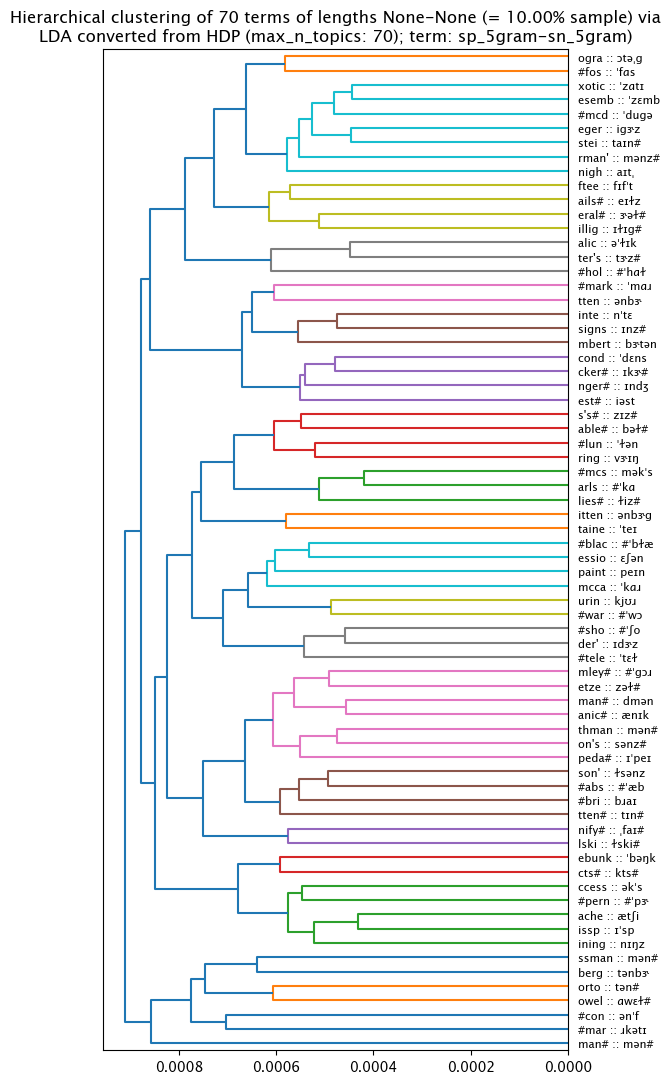

In [605]:
## term の階層クラスタリング: max_n_topics の値に拠ってparameters の最適値は異なる
## なるべく高い lowerst_density の設定が肝
HDP_helper.hc_clustering_terms_from_hdp (pair_hdp, pair_diction, term_type = term_type, n_topics= max_n_topics, lowest_density = 0.0036, sampling_rate = 0.1, gap_mark = gap_mark, use_CJK = False, check = False)

100


In [615]:
%%capture --no-display

## LDA のtopic ごとに，関連度の高い term を表示
import pandas as pd
n_terms = n_terms_to_show # topic ごとに表示する term 数の指定
print(f"n_terms_to_show: {n_terms_to_show}")

pair_topic_dfs = [ ]
for topic_id in range(max_n_topics):
    print(f"topic_id: {topic_id}")
    pair_terms = [ ]
    if use_HDP:
        for i, prob in pair_lda.show_topics(topic_id, num_words = n_terms):
            pair_terms.append(pair_diction.id2token[int(i)])
    else:
        for i, prob in model_used.get_topic_terms(topic_id, topn = n_terms):
            pair_terms.append(pair_diction.id2token[int(i)])
    pair_topic_dfs.append(pd.DataFrame([pair_terms], index = [ f'topic {topic_id}' ]))
#
df_terms_by_topics = pd.concat(pair_topic_dfs)

## Table として表示
#df_terms_by_topics.T
df_terms_by_topics

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
topic 0,#gro :: #ˈɡɹa,tzing :: tzɪŋ,zinge :: zɪŋɝ#,#gro :: #ˈɡɹ,tzin :: zɪŋɝ#,zinge :: ɪŋɝ#,nger# :: zɪŋɝ#,tzin :: tzɪŋ,zinge :: tzɪŋ,inger :: zɪŋɝ#,...,inge :: zɪŋɝ#,etzin :: zɪŋɝ#,#gret :: ˈɡɹɛ,#gre :: #ˈɡɹɛ,tler :: tɫɝ#,#gre :: ˈɡɹɛ,etzin :: tzɪŋɝ,etzin :: ɪŋɝ#,etzi :: zɪŋɝ#,ler# :: tɫɝ#
topic 1,ler# :: tɫɝ#,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
topic 2,#gro :: #ˈɡɹa,ler# :: tɫɝ#,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
topic 3,#gro :: #ˈɡɹa,etzi :: zɪŋɝ#,ler# :: tɫɝ#,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
topic 4,#gro :: #ˈɡɹa,tzing :: tzɪŋ,etzi :: zɪŋɝ#,ler# :: tɫɝ#,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
topic 65,#gro :: #ˈɡɹa,tzing :: tzɪŋ,zinge :: zɪŋɝ#,tzin :: zɪŋɝ#,#gro :: #ˈɡɹ,nger# :: zɪŋɝ#,zinge :: ɪŋɝ#,tzin :: tzɪŋ,zinge :: tzɪŋ,inger :: zɪŋɝ#,...,#gre :: ˈɡɹɛ,etzin :: tzɪŋɝ,etzin :: ɪŋɝ#,etzi :: zɪŋɝ#,ler# :: tɫɝ#,NaN,NaN,NaN,NaN,NaN
topic 66,#gro :: #ˈɡɹa,tzing :: tzɪŋ,zinge :: zɪŋɝ#,tzin :: zɪŋɝ#,#gro :: #ˈɡɹ,zinge :: ɪŋɝ#,nger# :: zɪŋɝ#,zinge :: tzɪŋ,tzin :: tzɪŋ,zing :: zɪŋɝ,...,#gre :: ˈɡɹɛ,tler :: tɫɝ#,etzin :: tzɪŋɝ,etzin :: ɪŋɝ#,etzi :: zɪŋɝ#,ler# :: tɫɝ#,NaN,NaN,NaN,NaN
topic 67,#gro :: #ˈɡɹa,tzing :: tzɪŋ,zinge :: zɪŋɝ#,tzin :: zɪŋɝ#,#gro :: #ˈɡɹ,nger# :: zɪŋɝ#,zinge :: ɪŋɝ#,tzin :: tzɪŋ,zinge :: tzɪŋ,zing :: zɪŋɝ,...,#gret :: ˈɡɹɛ,tler :: tɫɝ#,#gre :: ˈɡɹɛ,etzin :: tzɪŋɝ,etzin :: ɪŋɝ#,etzi :: zɪŋɝ#,ler# :: tɫɝ#,NaN,NaN,NaN
topic 68,#gro :: #ˈɡɹa,tzing :: tzɪŋ,zinge :: zɪŋɝ#,tzin :: zɪŋɝ#,#gro :: #ˈɡɹ,nger# :: zɪŋɝ#,zinge :: ɪŋɝ#,tzin :: tzɪŋ,zinge :: tzɪŋ,zing :: ɪŋɝ#,...,#gret :: ˈɡɹɛ,#gre :: #ˈɡɹɛ,#gre :: ˈɡɹɛ,tler :: tɫɝ#,etzin :: tzɪŋɝ,etzin :: ɪŋɝ#,etzi :: zɪŋɝ#,ler# :: tɫɝ#,NaN,NaN
